In [1]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

import datetime
import glob
import os
import time
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torch.autograd import Variable

n_epochs = 300

os.environ["CUDA_VISIBLE_DEVICES"]= "0" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


## Datasets

In [2]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

class ImageDataset(Dataset):
    def __init__(self, root, transform=None, unaligned=False, mode="train"):
        self.transform = transform
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    
    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return item_B, item_A
        # return {"A": item_A, "B": item_B}

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
    transforms.Resize((256,256)),
    transforms.RandomCrop((256,256)),
    transforms.RandomHorizontalFlip(),
])

In [4]:
# Training data loader
dataset = ImageDataset("/home/NAS_mount2/jwkim/data/facades", transform=transform, unaligned=True)
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=16,
)

# Test data loader
val_dataset = ImageDataset("/home/NAS_mount2/jwkim/data/facades", transform=transform, unaligned=True, mode="test")
val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
)

(-0.5, 255.5, 255.5, -0.5)

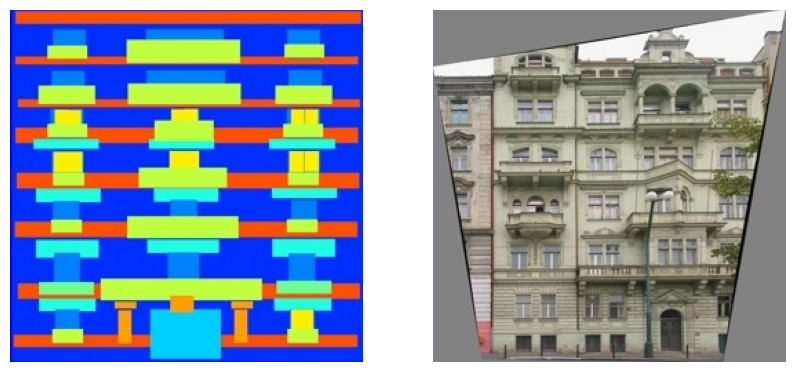

In [5]:
a,b = dataset[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

## Model

In [6]:
# 가중치 초기화
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [7]:
# Generator
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [9]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

## Train

In [10]:
input_shape = (3, 256, 256)

# _G_AB = GeneratorResNet(input_shape, 9).cuda()
# G_AB =  nn.DataParallel(_G_AB).to(device)
# _G_BA = GeneratorResNet(input_shape, 9).cuda()
# G_BA =  nn.DataParallel(_G_BA).to(device)
# _D_A = Discriminator(input_shape).cuda()
# D_A =  nn.DataParallel(_D_A).to(device)
# _D_B = Discriminator(input_shape).cuda()
# D_B =  nn.DataParallel(_D_B).to(device)

G_AB = GeneratorResNet(input_shape, 9).to(device)
G_BA = GeneratorResNet(input_shape, 9).to(device)
D_A = Discriminator(input_shape).to(device)
D_B = Discriminator(input_shape).to(device)

In [11]:
# 손실함수
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# 최적화 파라미터
lr = 2e-4
b1 = 0.5
b2 = 0.999

# Optimizer 
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, 0, 100).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, 0, 100).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs, 0, 100).step
)

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

## Train

In [15]:
from torchvision.utils import save_image, make_grid 

os.makedirs("images_cyclegan3", exist_ok=True)

def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    
    a,b = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    
    real_A = a.to(device)
    fake_B = G_AB(real_A)
    real_B = b.to(device)
    fake_A = G_BA(real_B)
    
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images_cyclegan3/%s.png" % batches_done, normalize=False)


In [16]:
import sys

In [19]:
prev_time = time.time()
loss_hist = {'gen':[],
             'dis':[]}

for epoch in range(n_epochs):
    for i, (a,b) in enumerate(dataloader):
        ba_si = a.size(0)
        
        # Set model input
        real_A = a.to(device)
        real_B = b.to(device)

        # Adversarial ground truths
        valid = torch.ones(ba_si, *D_A.output_shape, requires_grad=False).to(device)
        fake = torch.zeros(ba_si, *D_A.output_shape, requires_grad=False).to(device)

        # ------------------
        #  Train Generators
        # ------------------

        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------

        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )
        
        loss_hist['gen'].append(loss_G.item())
        loss_hist['dis'].append(loss_D.item())
        
        # If at sample interval save image
        if batches_done % 500 == 0:
            sample_images(batches_done)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

[Epoch 299/300] [Batch 399/400] [D loss: 0.015134] [G loss: 1.666343, adv: 0.807578, cycle: 0.069070, identity: 0.033614] ETA: 0:00:00.1748546459746

In [20]:
torch.save(G_AB.state_dict(), "models/cyclegan_G_AB3")
torch.save(G_BA.state_dict(), "models/cyclegan_G_BA3")
torch.save(D_A.state_dict(), "models/cyclegan_D_A3")
torch.save(D_B.state_dict(), "models/cyclegan_D_B3")

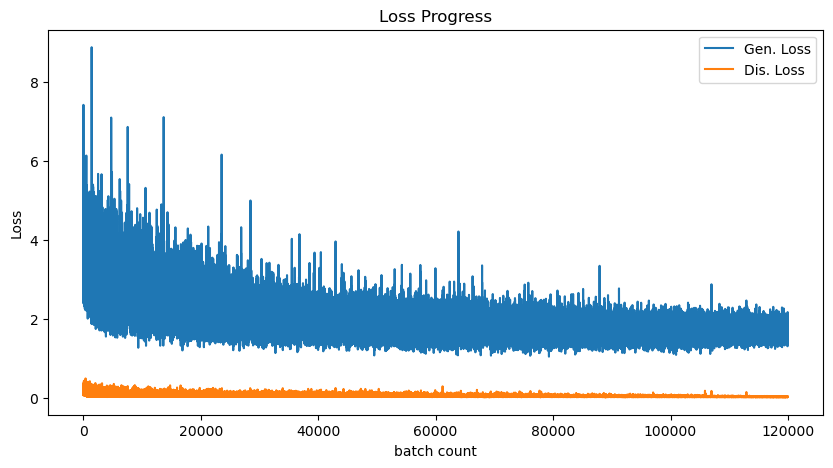

In [21]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    
    a,b = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    
    real_A = a.to(device)
    fake_B = G_AB(real_A)
    real_B = b.to(device)
    fake_A = G_BA(real_B)
    
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images_cyclegan3/%s.png" % batches_done, normalize=False)

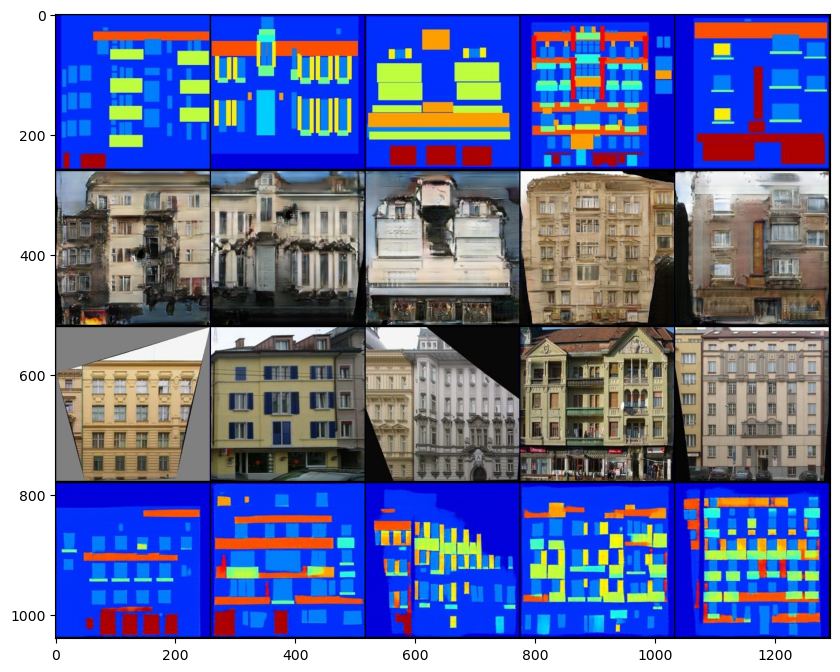

In [36]:
# Test data loader
val_dataset = ImageDataset("/home/NAS_mount2/jwkim/data/facades", transform=transform, unaligned=True, mode="test")
val_dataloader = DataLoader(
    val_dataset,
    batch_size=5,
    shuffle=True,
    num_workers=1,
)

# evaluation model
a,b = next(iter(val_dataloader))
G_AB.eval()
G_BA.eval()

real_A = a.to(device)
fake_B = G_AB(real_A)
real_B = b.to(device)
fake_A = G_BA(real_B)

real_A = make_grid(real_A, nrow=5, normalize=True)
real_B = make_grid(real_B, nrow=5, normalize=True)
fake_A = make_grid(fake_A, nrow=5, normalize=True)
fake_B = make_grid(fake_B, nrow=5, normalize=True)
    
# 시각화
image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)

plt.figure(figsize=(10,10))
plt.imshow(to_pil_image(image_grid))
save_image(image_grid, "/home/NAS_mount2/jwkim/images/cyclegan_1/b1_3.png", normalize=False)